## Importacion de librerias

#### Sistema

In [1]:
import os
import sys
import glob
sys.path.append('../')

#### Exploración de datos y visualización

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

#### Manejo de Rasters

In [3]:
import rasterio as rio
import geopandas as gpd

#### Entrenamiento

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib

2023-10-03 21:49:00.385608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 21:49:00.516307: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-03 21:49:01.067033: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/theend/miniconda3/envs/soil-env/lib/python3.8/site-packages/nvidia/cudnn/lib:/home/theend/miniconda3/envs/soil-env/lib/:/usr/local/cuda-11.8/lib64:
2023-10-03 21:49:01.067089: W tensorflow/stream_executor/p

In [5]:
from src.layers.utilities import plot_merge_class, process_data_points, locations_of_pixels, plot_confusion_matrix

#### Establecer semilla aleatoria para la reproductibilidad

In [6]:
# Set a random seed
RANDOM_SEED = 21

# Set random state for Python
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# Set random state for Python random function
random.seed(RANDOM_SEED)

# Set random state for NumPy
np.random.seed(RANDOM_SEED)

# Set random state for TensorFlow
tf.random.set_seed(RANDOM_SEED)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

#### Verificar GPU

In [7]:
def print_info():
    tf_version = tf.__version__
    gpus = [x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']
    cuda_version = tf.sysconfig.get_build_info()['cuda_version']
    cudnn_version = tf.sysconfig.get_build_info()['cudnn_version']
    
    print('Versión de TensorFlow: {}'.format(tf_version))
    print('GPU: {}'.format(gpus))
    print('Versión Cuda: {}'.format(cuda_version))
    print('Versión Cudnn: {}\n'.format(cudnn_version))

print_info()

Versión de TensorFlow: 2.10.1
GPU: ['device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6']
Versión Cuda: 11.2
Versión Cudnn: 8



2023-10-03 21:49:01.745856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 21:49:01.763656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-03 21:49:01.785202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-03 21:49:01.785439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Entrenamiento Modelo

In [8]:
from src.layers.dict_class import LandCoverClassDict
dict_class = LandCoverClassDict()

#### Diccionarios e identificadores de clase

In [9]:
class_names = dict_class.get_landsat_dictionary()
class_names

{0: 'Sin Clasificar',
 1: 'Bosque',
 2: 'Cuerpo de Agua',
 3: 'Otras Tierras',
 4: 'Tierra Agropecuaria',
 5: 'Vegetacion Arbustiva y Herbacea',
 6: 'Zona Antropica'}

In [10]:
colors_class = dict_class.get_colors_dictionary()
colors_class

{0: (0, 0, 0),
 1: (62, 178, 49),
 2: (0, 0, 251),
 3: (122, 125, 74),
 4: (245, 106, 0),
 5: (255, 165, 81),
 6: (255, 0, 0)}

### Procesamiento de la imagen de etiquetas NLDC

In [11]:
from src.controllers.raster import RasterController
raster = RasterController()

#### Configuracion de directiorios de los mosaicos (labels, rasters)

In [12]:
label_path = '../data/images/processed/labels/landsat/LANDCOVER-ECUADOR-2020.tif'
rasters_path = '../data/images/processed/products/landsat/toa/'

tiles = {}
landsat_datasets = {}
#path row year
tiles['106313'] = ['20130808', '20131011', '20131011', '20131128', '20141030']
tiles['106316'] = ['20161120', '20170819', '20170920', '20180907', '20180619']
tiles['106320'] = ['20200912', '20200827', '20200811', '20200608', '20200608']
printed_images = {}

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    tile = os.listdir(f'../data/images/processed/products/landsat/toa/20{tile_number[-2:]}/')
    for date in dates:
        for x in tile:
            if x.__contains__(date) and x not in printed_images:
                printed_images[x] = True
                l8_image_paths.append(f'../data/images/processed/products/landsat/toa/20{tile_number[-2:]}/{x}')
    for fp in l8_image_paths:
        tile_datasets.append(rio.open(fp))
    landsat_datasets[tile_number] = tile_datasets       

#### Abrir Mosaico

In [13]:
dataset_labels = raster.open_raster(raster=label_path)

Number of bands in the image: 1

Image size: 23910 rows x 21908 columns

Raster driver: GTiff

Image projection:
 EPSG:32617



#### Lectura de mosaico

In [14]:
labels_image = raster.read_raster(dataset_labels)
labels_image.shape

(1, 23910, 21908)

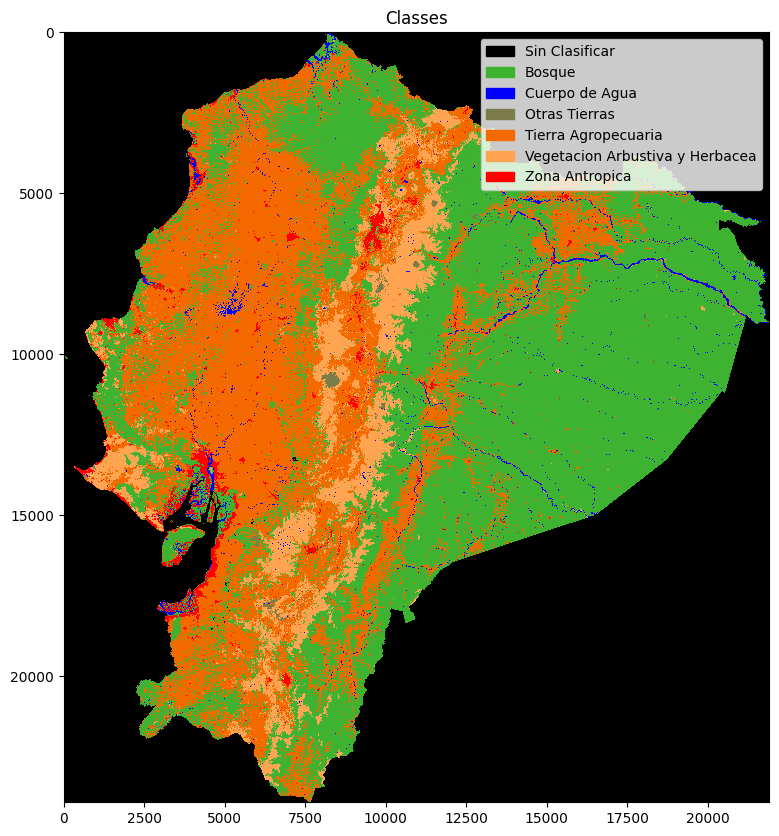

In [15]:
plot_merge_class(labels_image, colors_class, class_names)

#### Generar datos de entrenamiento balanceados

In [16]:
from src.controllers.pixel import PixelController
pixel = PixelController(label_dataset=dataset_labels)

In [17]:
tile_date = ['2013', '2016', '2018']
landsat_datasets = []
for date in tile_date:
    date_paths = glob.glob(os.path.join(rasters_path, date, '*'))
    date_paths.sort()
    for tile_path in date_paths:
        landsat_datasets.append(rio.open(tile_path))
landsat_datasets

[<open DatasetReader name='../data/images/processed/products/landsat/toa/2013/LC08_L1TP_010063_20130808_20200912_02_T1_MCT.tif' mode='r'>,
 <open DatasetReader name='../data/images/processed/products/landsat/toa/2013/LC08_L1TP_010063_20131011_20200912_02_T1_MCT.tif' mode='r'>,
 <open DatasetReader name='../data/images/processed/products/landsat/toa/2013/LC08_L1TP_010063_20131128_20200912_02_T1_MCT.tif' mode='r'>,
 <open DatasetReader name='../data/images/processed/products/landsat/toa/2013/LC08_L1TP_010063_20141030_20200910_02_T1_MCT.tif' mode='r'>,
 <open DatasetReader name='../data/images/processed/products/landsat/toa/2013/LC08_L1TP_010063_20150915_20200908_02_T1_MCT.tif' mode='r'>,
 <open DatasetReader name='../data/images/processed/products/landsat/toa/2016/LC08_L1TP_010063_20151001_20200908_02_T1_MCT.tif' mode='r'>,
 <open DatasetReader name='../data/images/processed/products/landsat/toa/2016/LC08_L1TP_010063_20161120_20170318_01_T1_MCT.tif' mode='r'>,
 <open DatasetReader name='

train_pixels = pixel.generate_training_pixels(
    image_datasets=landsat_datasets,
    train_count=80000,
    merge=True
)

#### Data Validation
- Balanced and accurate dataset.
- Actual pixel locations.

label_locations = process_data_points(train_pixels=train_pixels, landsat_datasets=landsat_datasets, dataset_labels=dataset_labels)

locations_of_pixels(labels=labels_image, locations=label_locations, colors=colors_class)

In [18]:
train_gdf = gpd.read_file('../data/shape/pixels/train/train_pixels.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['index']))

random.shuffle(train_px)

len(train_px), train_px[0]

(56007, ((1476, 2161), 12))

In [19]:
train_gdf.head(5)

,index,row,col,geometry
0,11,20,3978,POINT (20.000 3978.000)
1,1,2675,221,POINT (2675.000 221.000)
2,1,963,4564,POINT (963.000 4564.000)
3,13,3918,2322,POINT (3918.000 2322.000)
4,9,1217,436,POINT (1217.000 436.000)


In [20]:
val_gdf = gpd.read_file('../data/shape/pixels/val/val_pixels.shp')
val_px = []
for index, row in val_gdf.iterrows():
    val_px.append(((row['row'], row['col']), row['index']))

random.shuffle(val_px)

len(val_px), val_px[0]

(24003, ((186, 1058), 13))

In [21]:
val_gdf.head(5)

,index,row,col,geometry
0,11,1037,1686,POINT (1037.000 1686.000)
1,2,3329,3032,POINT (3329.000 3032.000)
2,12,120,3747,POINT (120.000 3747.000)
3,8,922,3365,POINT (922.000 3365.000)
4,13,125,3907,POINT (125.000 3907.000)


In [22]:
import gc
gc.collect()

0

## Probando el generador de datos

In [23]:
from src.controllers.tile import TileController

In [24]:
#%run "/home/theend/Documentos/Develop/Python/Jupyter/soil_desertification/src/controllers/tile.py"

In [25]:
im_batch = None

count = 0
for (im, label) in  next(TileController(landsat_datasets, dataset_labels, 128, 128, train_px, 10)):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----
Image
(10, 128, 128, 7)
Label
(10, 7)
----


In [26]:
def normalize(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-6)

In [27]:
def plot_images_with_labels(image_batch, label_batch, class_names):
    num_images = image_batch.shape[0]
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.62 * 10, 10))

    for i in range(num_images):
        row = i // num_cols
        col = i % num_cols

        axes[row, col].imshow(normalize(image_batch[i, :, :, 3:6]))
        axes[row, col].set_title(class_names[np.argmax(label_batch[i])])

    # Remove any empty subplots
    for i in range(num_images, num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

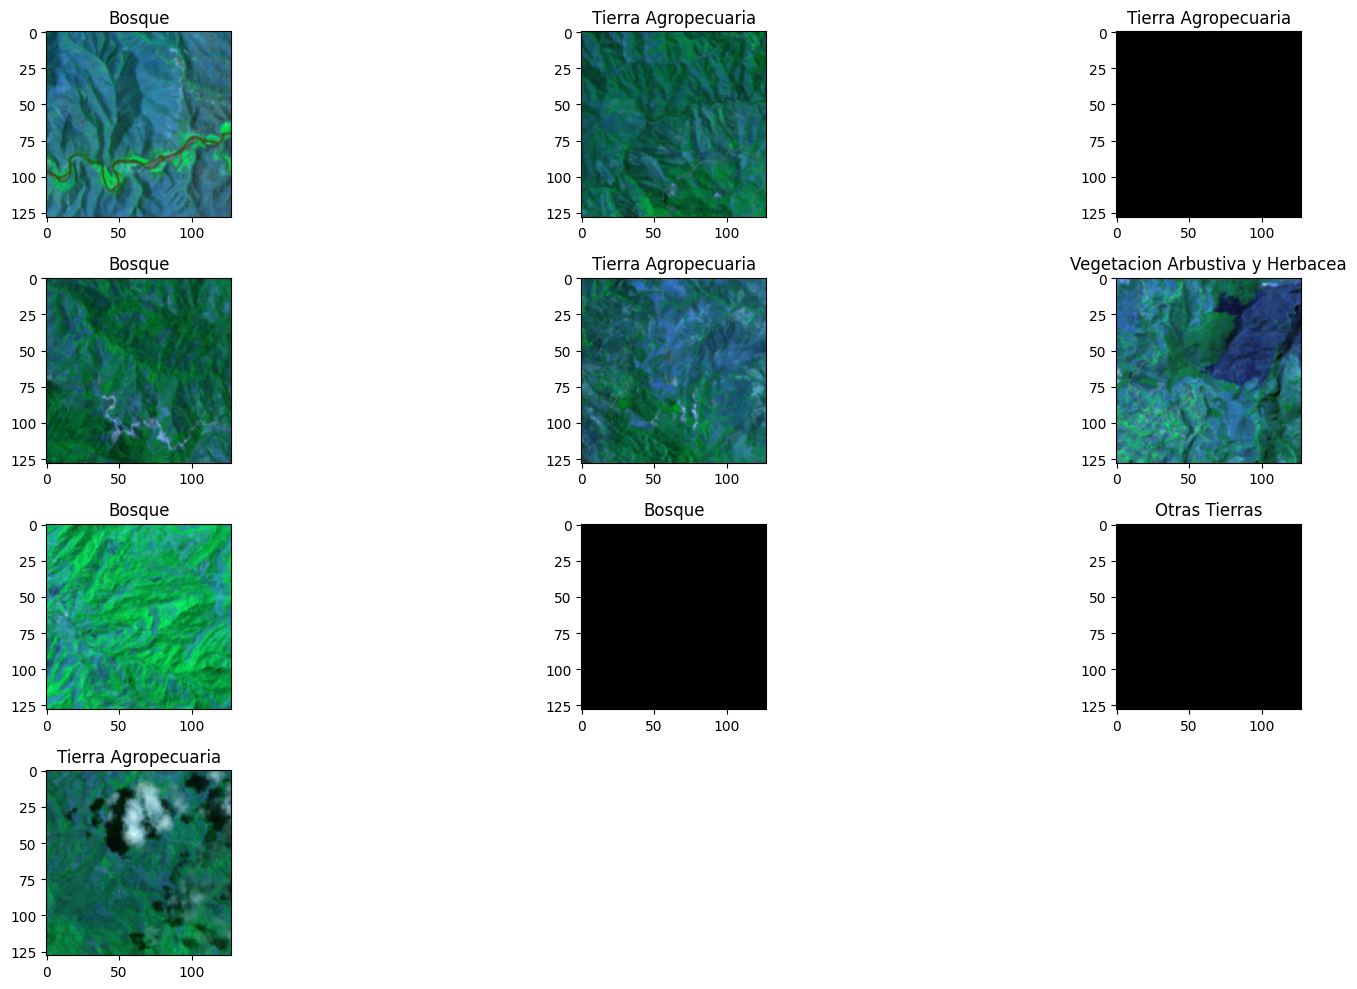

In [28]:
plot_images_with_labels(im_batch, label_batch, class_names)

#### Generar conjunto de datos de entrenamiento de 1x1 azulejos para scikit-learn para visualizar los datos

In [29]:
im_batch = None
label_batch = None

sample_size = 500

count = 0
for (im, label) in next(TileController(images=landsat_datasets, label=dataset_labels, height=1, width=1, pixel_locations=train_px, batch_size=sample_size)):
    if count > 0:
        break
    print('Batch Shape')
    print(im.shape)
    print('Label Shape')
    print(label.shape)
    print('----')
    count += 1
    im_batch = im
    label_batch = label

Batch Shape
(500, 1, 1, 7)
Label Shape
(500, 7)
----


#### Redimencionar 
Remodelar porque scikit-learn necesita datos en formato `(muestras, bandas)`:

In [30]:
im_batch[0, :, :, :]

array([[[ 5.07710172,  3.84904784,  3.04737575,  2.02275894,
         13.50441245,  7.38736647,  3.10404087]]])

In [31]:
im_batch_reshaped = im_batch.reshape(sample_size, 7)
im_batch_reshaped[0]

array([ 5.07710172,  3.84904784,  3.04737575,  2.02275894, 13.50441245,
        7.38736647,  3.10404087])

#### Visualizar Firmas Espectrales

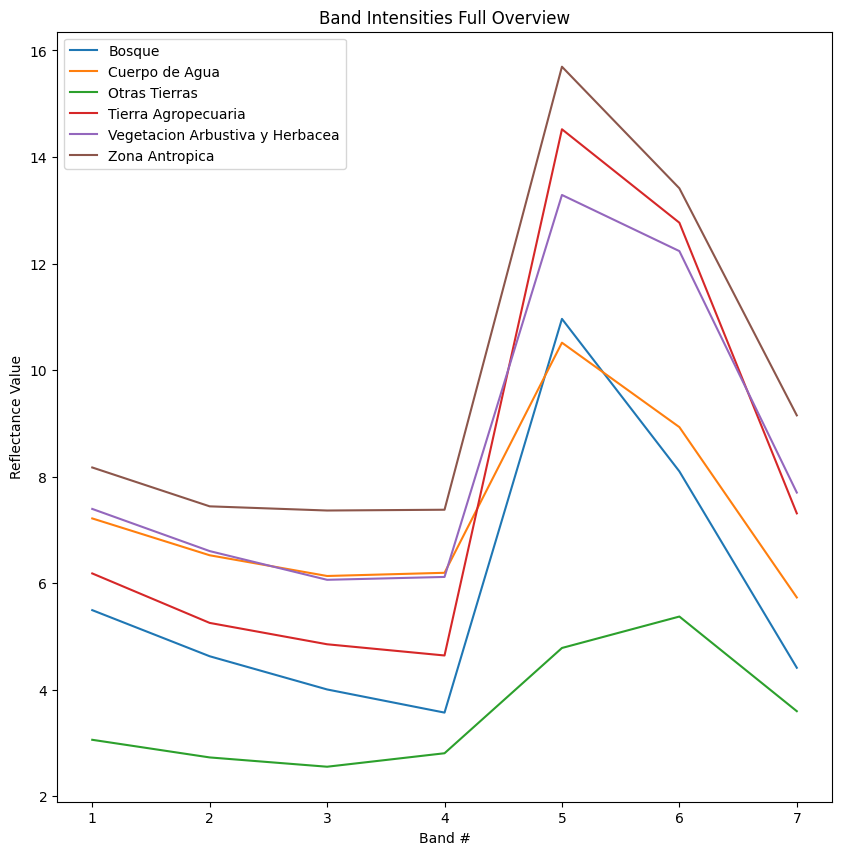

In [32]:
fig, ax = plt.subplots(1, 1, figsize=[10, 10])

# numbers 1-8
band_count = np.arange(1, 8)

y = np.argmax(label_batch, axis=1)
X = im_batch_reshaped

classes = np.unique(y)
for class_type in classes:
    band_intensity = np.mean(X[y == class_type, :], axis=0)
    ax.plot(band_count, band_intensity, label=class_names[class_type])
# plot them as lines

# Add some axis labels
ax.set_xlabel('Band #')
ax.set_ylabel('Reflectance Value')
# Add a titleA
ax.set_title('Band Intensities Full Overview')
ax.legend(loc='upper left')

## Arquitectura, entrenamiento y validación de la RNN

In [33]:
from keras.models import Sequential
from keras.layers import (
    Bidirectional,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    LSTM,
    MaxPooling2D,
    Reshape,
    BatchNormalization,
    Activation,
    Concatenate
)
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

#### Establecer los hiperparámetros

In [34]:
epochs = 60
batch_size = 32
dropout_rate = 0.3
learning_rate = 0.001
steps_division_factor = 2
num_classes = len(class_names)

# dimensiones de la imagen de entrada
tile_size = 32
img_rows, img_cols = tile_size, tile_size
img_bands = landsat_datasets[0].count - 1

input_shape = (img_rows, img_cols, img_bands)
print(input_shape)

(32, 32, 7)


#### Arquitectura CNN

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Agregamos una capa de Reshape para convertir la salida en 3D
model.add(Reshape((1, 1024)))

# Agregamos dos capas Bidirectional LSTM
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.01))))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))  # Dropout adicional

model.add(Dense(128, kernel_regularizer=l2(0.01)))  # Regularización L2 en capa densa
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout adicional

model.add(Dense(128, kernel_regularizer=l2(0.01)))  # Regularización L2 en capa densa
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout adicional

model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(tile_size, tile_size, 7), padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Add residual connection
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", padding='same'))
model.add(BatchNormalization())


model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu", padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax"))

model.summary()

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Factor de regularización L2
l2_reg = 0.001  # Puedes ajustar este valor según tus necesidades

# Crea un modelo secuencial
model = Sequential()

# Capa convolucional con filtro de 32 y kernel de 3x3
model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", input_shape=(tile_size, tile_size, 7), padding='same', kernel_regularizer=l2(l2_reg)))

# Capa convolucional adicional con kernel de 3x3 y regularización L2
model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_regularizer=l2(l2_reg)))

# Capa de normalización por lotes
model.add(BatchNormalization())

# Capa de agrupación máxima
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa de abandono (dropout)
model.add(Dropout(dropout_rate))

# Capas residuales (repetir este bloque para aumentar profundidad)
model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_regularizer=l2(l2_reg)))
model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())

# Capa de agrupación máxima
model.add(MaxPooling2D(pool_size=(2, 2)))

# Capa de abandono (dropout)
model.add(Dropout(dropout_rate))

# Más capas convolucionales y residuales (según sea necesario)

# Capas completamente conectadas con regularización L2
model.add(Flatten())
model.add(Dense(256, activation="elu", kernel_regularizer=l2(l2_reg)))
model.add(Dropout(dropout_rate))
model.add(Dense(128, activation="elu", kernel_regularizer=l2(l2_reg)))
model.add(Dropout(dropout_rate))
model.add(Dense(64, activation="elu", kernel_regularizer=l2(l2_reg)))
model.add(Dropout(dropout_rate))

# Capa de salida con activación softmax
model.add(Dense(num_classes, activation="softmax"))

# Resumen del modelo
model.summary()

# Optimizador Adam
optimizer = Adam(learning_rate=learning_rate)

# Compila el modelo
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [35]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", input_shape=(tile_size, tile_size, 7), padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Add residual connection
model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same', kernel_regularizer=l2(0.001)))
model.add(Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="elu", kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation="elu", kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(64, activation="elu", kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation="softmax"))

model.summary()

optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2048      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9

2023-10-03 21:49:19.981952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-03 21:49:19.982182: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-03 21:49:19.982304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-03 21:49:19.982615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-03 21:49:19.982743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

##### Divida los datos en entrenamiento y validación

train_to_val_ratio = 0.7
train_px = train_pixels[:int(len(train_pixels)*train_to_val_ratio)]
val_px = train_pixels[int(len(train_pixels)*train_to_val_ratio):]
print("# Training samples: {n_training} \n# Validation samples: {n_val}".format(n_training=len(train_px), n_val=len(val_px)))

##### Tensforflow Callbacks

In [36]:
class CreateAccuracyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.75):
            print(f"La precisión alcanzó el {75 * 100}% en la época {epoch}. Deteniendo el entrenamiento.")
            self.model.stop_training = True

In [37]:
accuracy_callback = CreateAccuracyCallback()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard = TensorBoard(log_dir='../reports/landsat/v4/logs')
checkpoint = ModelCheckpoint('../models/v4/landsat.h5', monitor='accuracy', verbose=1, save_best_only=True, mode='max')

In [38]:
history = model.fit(
    next(TileController(landsat_datasets,
        dataset_labels,
        tile_size,
        tile_size,
        train_px,
        batch_size)),
    steps_per_epoch=len(train_px) // batch_size // steps_division_factor, epochs=epochs, verbose=1,
    validation_data=next(
    TileController(landsat_datasets,
        dataset_labels,
        tile_size, 
        tile_size,
        val_px,
        batch_size)),
    validation_steps=len(val_px) // batch_size,
    callbacks=[accuracy_callback, early_stopping, checkpoint, tensorboard]
)

Epoch 1/60


2023-10-03 21:49:21.869895: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


  1/875 [..............................] - ETA: 32:04 - loss: 4.5998 - accuracy: 0.1250

2023-10-03 21:49:22.456800: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


875/875 [==============================] - ETA: 0s - loss: 2.2115 - accuracy: 0.4270
Epoch 1: accuracy improved from -inf to 0.42696, saving model to ../models/v4/landsat.h5
875/875 [==============================] - 562s 640ms/step - loss: 2.2115 - accuracy: 0.4270 - val_loss: 2.0823 - val_accuracy: 0.4131
Epoch 2/60
875/875 [==============================] - ETA: 0s - loss: 1.6140 - accuracy: 0.5564
Epoch 2: accuracy improved from 0.42696 to 0.55639, saving model to ../models/v4/landsat.h5
875/875 [==============================] - 562s 643ms/step - loss: 1.6140 - accuracy: 0.5564 - val_loss: 1.6336 - val_accuracy: 0.5192
Epoch 3/60
875/875 [==============================] - ETA: 0s - loss: 1.3804 - accuracy: 0.5871
Epoch 3: accuracy improved from 0.55639 to 0.58707, saving model to ../models/v4/landsat.h5
875/875 [==============================] - 563s 644ms/step - loss: 1.3804 - accuracy: 0.5871 - val_loss: 1.8052 - val_accuracy: 0.4610
Epoch 4/60
875/875 [=========================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


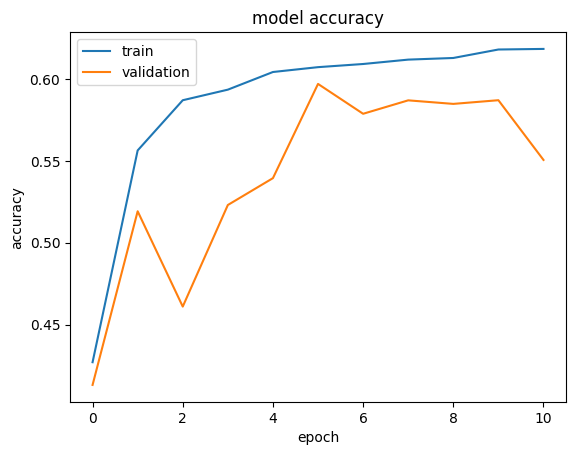

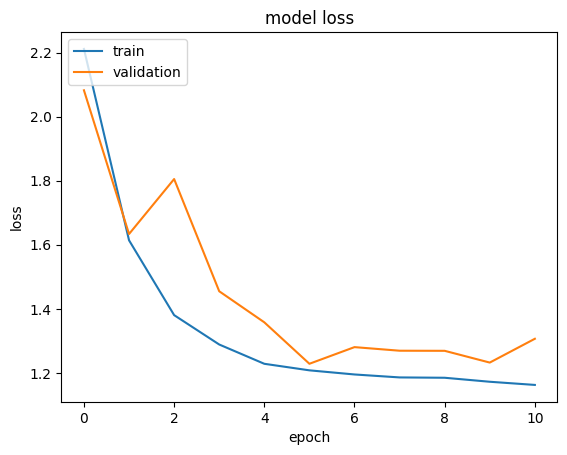

In [39]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Comprobar el resultado con los datos de validación

In [40]:
predictions = model.predict(
    next(
        TileController(
            landsat_datasets, 
            dataset_labels,
            tile_size, 
            tile_size, 
            val_px, 
            batch_size
        )
    ),
    steps=len(val_px) // batch_size,
    verbose=1,
)

750/750 [==============================] - 251s 335ms/step


In [41]:
eval_generator = next(
    TileController(
        landsat_datasets, 
        dataset_labels, 
        tile_size, 
        tile_size, 
        val_px, 
        batch_size=1
    )
)

In [42]:
predictions.shape

(24000, 7)

In [43]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

#### Trazar matriz de confusión no normalizada

<Axes: title={'center': 'Confusion matrix - Unnormalized'}, xlabel='Predicted Label', ylabel='True Label'>

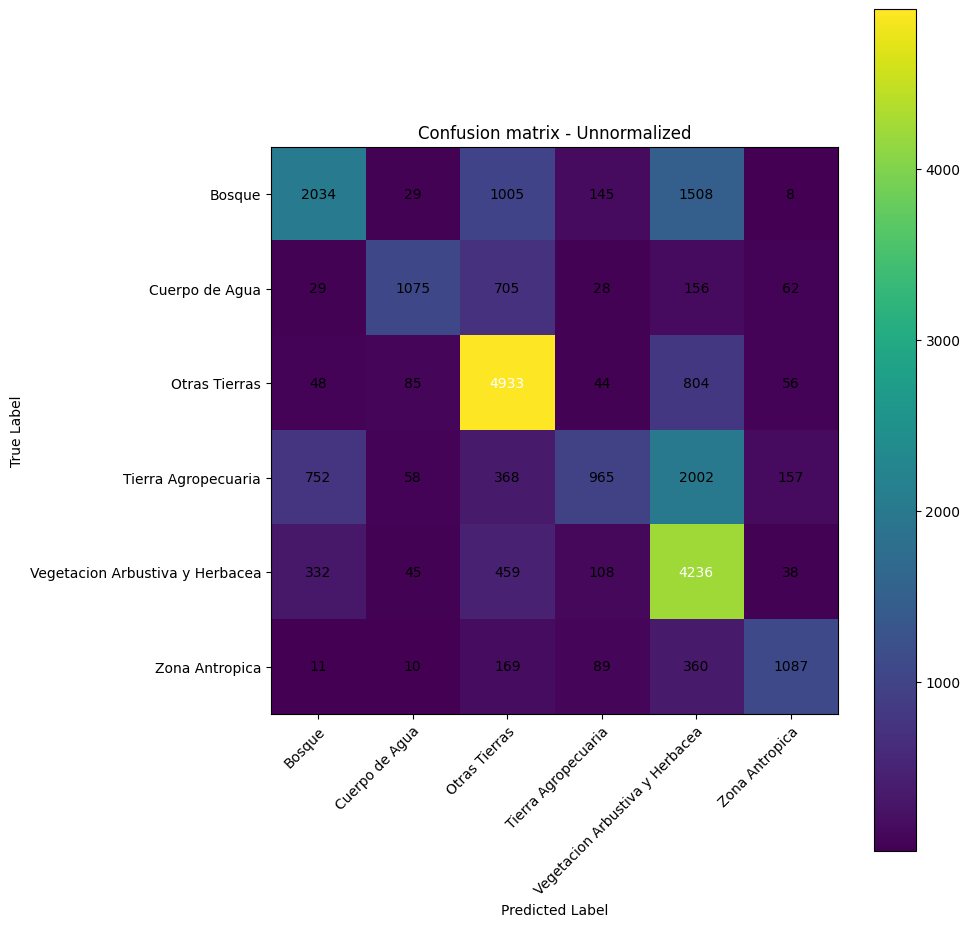

In [44]:
plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Unnormalized',
    normalize=False
)

#### Trazar matriz de confusión normalizada

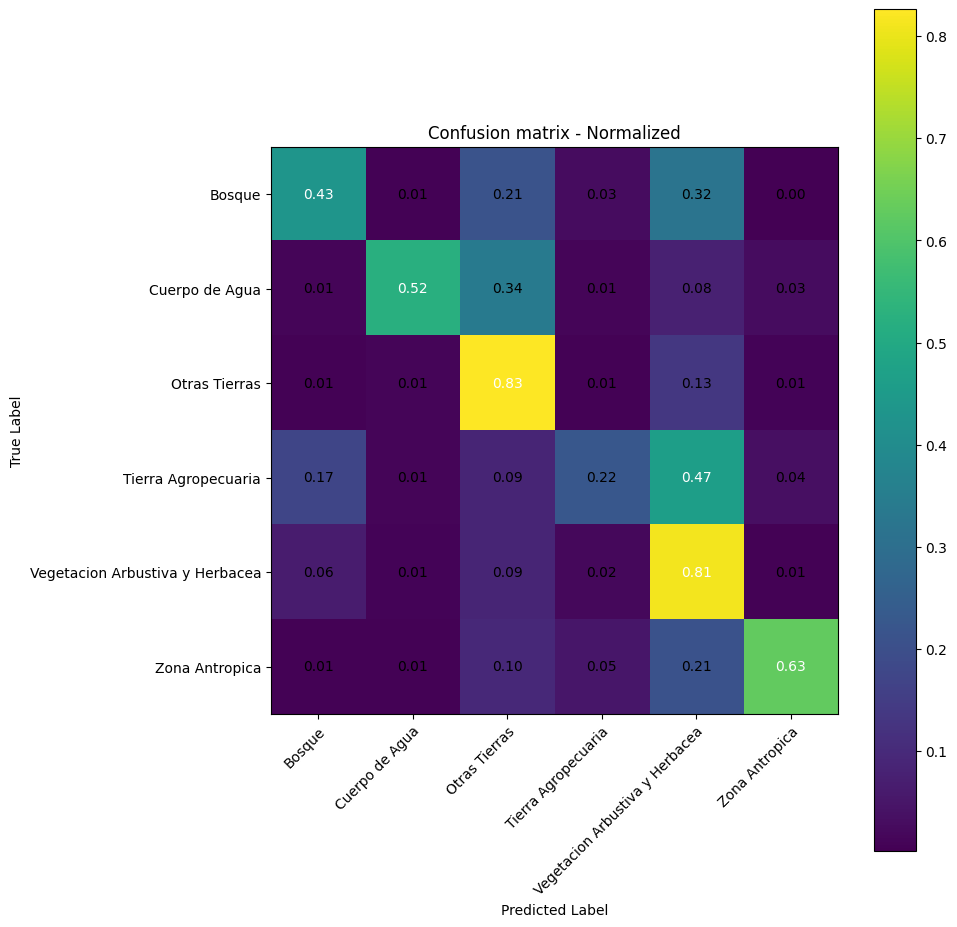

In [45]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Normalized',
    normalize=True
)

In [46]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

Accuracy: 59.71%
Precision: 63.89%
Recall: 59.71%
F1 score: 57.59%


### Comprobar el resultado con los datos de entrenamiento

In [47]:
predictions = model.predict(
    next(
        TileController(
            landsat_datasets,
            dataset_labels, 
            tile_size, 
            tile_size,
            train_px, 
            batch_size
        )
    ),
    steps=len(train_px) // batch_size,
    verbose=1,
)

  69/1750 [>.............................] - ETA: 9:41

In [ ]:
predictions = model.predict(
    next(
        TileController(
            landsat_datasets, dataset_labels, tile_size, tile_size, train_px, batch_size
        )
    ),
    steps=len(train_px) // batch_size,
    verbose=1,
)

In [ ]:
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

label_index = np.argmax(labels, axis=1)
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

#### Trazar matriz de confusión no normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Unnormalized',
    normalize=False
)

#### Trazar matriz de confusión normalizada

In [ ]:
_ = plot_confusion_matrix(
    label_index,
    pred_index,
    class_dict=class_names,
    title='Confusion matrix - Normalized',
    normalize=True
)

In [ ]:
print("Accuracy: {accuracy:.2f}%".format(accuracy=accuracy_score(label_index, pred_index)*100))
print("Precision: {precision:.2f}%".format(precision=precision_score(label_index, pred_index, average='weighted')*100))
print("Recall: {recall:.2f}%".format(recall=recall_score(label_index, pred_index, average='weighted')*100))
print("F1 score: {f1:.2f}%".format(f1=f1_score(label_index, pred_index, average='weighted')*100))

In [ ]:
print("IPython Notebook execution completed!")